In [9]:
# Colab: Make sure both fraudTrain.csv and fraudTest.csv are uploaded

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
# Load training and test datasets
df_train = pd.read_csv('fraudTrain.csv')
df_test = pd.read_csv('fraudTest.csv')

# Combine for preprocessing
df = pd.concat([df_train, df_test], ignore_index=True)
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [15]:
def preprocess_data(df):
    df = df.copy()

    # Extract hour and day from timestamp
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['dayofweek'] = df['trans_date_trans_time'].dt.dayofweek

    # Select key features based on transaction behavior
    selected_features = ['amt', 'category', 'merchant', 'gender', 'city', 'state', 'hour', 'dayofweek']

    # Encode categorical features
    encoders = {}
    for col in selected_features:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col + '_enc'] = le.fit_transform(df[col])
            encoders[col] = le
        else:
            df[col + '_enc'] = df[col]

    # Final feature list
    feature_cols = [f + '_enc' for f in selected_features]

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_cols])

    y = df['is_fraud']

    return X_scaled, y, feature_cols, encoders


In [16]:
X_scaled, y, feature_cols, encoders = preprocess_data(df)


In [17]:
def train_and_evaluate(X, y):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Train
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    print("\n🔍 Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

    print(f"\n📈 ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

    return model, X_test, y_test, y_pred, y_proba



📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552824
           1       0.92      0.70      0.79      2895

    accuracy                           1.00    555719
   macro avg       0.96      0.85      0.90    555719
weighted avg       1.00      1.00      1.00    555719


🔍 Confusion Matrix:


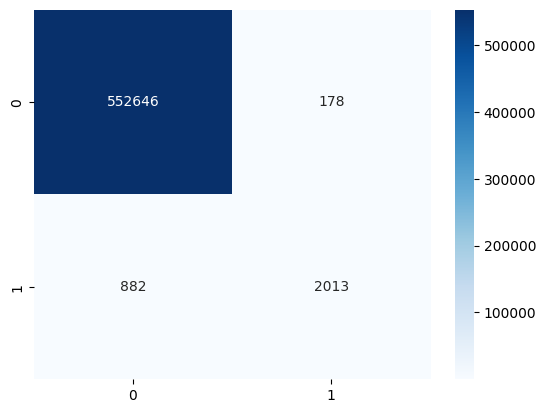


📈 ROC AUC Score: 0.9794


In [18]:
model, X_test, y_test, y_pred, y_proba = train_and_evaluate(X_scaled, y)


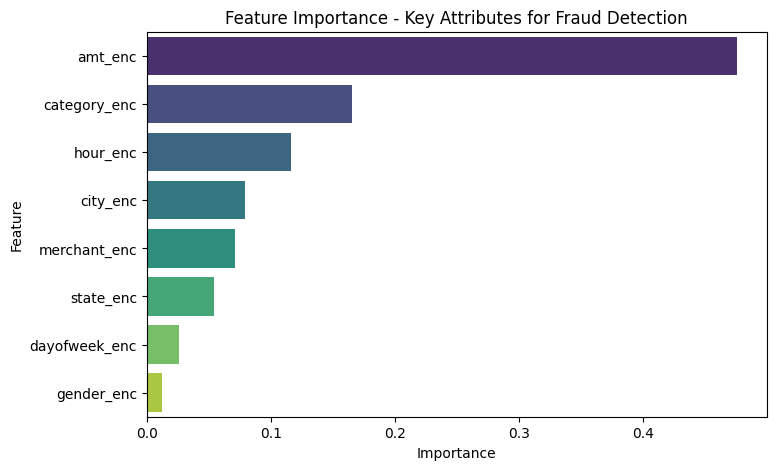

In [21]:
# Feature Importance
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], hue=np.array(feature_names)[indices], palette='viridis', legend=False)
    plt.title('Feature Importance - Key Attributes for Fraud Detection')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Plot
plot_feature_importance(model, feature_cols)



In [22]:
def analyze_misclassifications(y_true, y_pred):
    errors = y_true != y_pred
    false_positives = np.logical_and(errors, y_pred == 1)
    false_negatives = np.logical_and(errors, y_pred == 0)

    print(f"\n🚫 False Positives: {false_positives.sum()}")
    print(f"🚫 False Negatives: {false_negatives.sum()}")

    return false_positives, false_negatives

# Run analysis
false_positives, false_negatives = analyze_misclassifications(y_test.values, y_pred)



🚫 False Positives: 178
🚫 False Negatives: 882


In [4]:
#Explore the dataset
print("Shape of the dataset:", df.shape)
print("\nSummary statistics:")
print(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nClass distribution:")
print(df['Class'].value_counts())  # 0 = Normal, 1 = Fraud


Shape of the dataset: (284807, 31)

Summary statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.